In [1]:
import numpy
from scipy.fftpack import fft,fft2, fftshift
from scipy.fftpack import dct
from scipy.signal import resample
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.io.wavfile import read
from scipy.io.wavfile import write
import shlex, subprocess, os

%matplotlib inline

In [2]:
def audio_converter(file, target_sample_rate, target_channels, num_bits=16):
    filename = os.path.basename(os.path.splitext(file)[0])
    extension = os.path.splitext(file)[1]
    filepath = os.path.dirname(file) + os.sep
    temp_output = filepath + filename + "_resampled_"+extension
    sox_args = shlex.split("sox {} -r {} -b {} {} channels {}".format(file,target_sample_rate, num_bits, temp_output, target_channels))
    sox_output = subprocess.check_output(sox_args)
    sr, signal = read(temp_output)
    channels = signal.shape[1] if len(signal.shape) > 1 else 1
    if sr == target_sample_rate and channels == target_channels:
        os.remove(temp_output)
        return sr, channels, signal
    else:
        raise ValueError("Error occurred during conversion of file {} to sample rate {} "\
                         "and channels {} (result: {} and {} with output file {})".format(
                             file,
                             target_sample_rate,
                             target_channels,
                             sr,
                             channels,
                             temp_output
                         ))

In [3]:
def load_wav_file(file, sample_rate):
    sr, signal = read(file)
    channels = signal.shape[1] if len(signal.shape) > 1 else 1
    print("Read file with duration {} seconds and sample rate {} and {} channels".format(signal.shape[0]/sr, sr, channels))
    if sr != sample_rate or channels != 1:
        sr, channels, signal = audio_converter(file, target_sample_rate=sample_rate, target_channels=1)
        print("Resampled file with duration {} seconds and sample rate {} and {} channels".format(signal.shape[0]/sr, sr, channels))
    return signal

In [4]:
def emphasize_signal(signal, pre_emphasis=0.97):
    #A pre-emphasis filter is useful in several ways:
    #  (1) balance frequency spectrum: high frequencies usually have smaller magnitudes vs lower frequencies
    #  (2) avoid numerical problems during the Fourier transform operation
    #  (3) improve the Signal-to-Noise Ratio (SNR)
    # Pre-emphasis between 0.95 and 0.97
    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return emphasized_signal

In [5]:
def framing(signal, sample_rate, frame_size=0.025, frame_stride=0.01):
    #Split signal into short time frames so we can do a Fourier transform on them. 
    #With this we can obtain a good approximation of the frequency contours of the
    #signal by concatenating adjacent frames. Parameters:
    # frame_size - range from 20 ms to 40 ms 
    # frame_stride - range from 40-60% overlap of the frame_size. The input is in ms
    # sample_rate - the signal's sample rate
    frame_length = frame_size * sample_rate
    frame_step = frame_stride * sample_rate
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    # Make sure that we have at least 1 frame:
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))
    # Pad Signal to make sure that all frames have equal number of samples without
    #truncating any samples from the original signal
    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(signal, z)

    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]
    return frames

In [6]:
def smoothing_window(frames, frame_length, window_type='hamming'):
    #Apply a Hamming window that effectively filters high frequencies.
    #This is counteract the assumption made by the Fourier Transforms
    #that the data is infinite and we reduce spectral leakage
    if window_type == 'hamming': frames *= numpy.hamming(frame_length)
    elif window_type == 'hanning': frames *= numpy.hanning(frame_length)
    elif window_type == 'blackman': frames *= numpy.blackman(frame_length)
    else: raise ValueError("Unknown smoothing function {}".format(window_type))
    return frames

In [7]:
def fourier_transform_and_power_spectrum(frames, nfft=512):
    #We apply the real fft since the the negative frequency terms are
    #just the complex conjugates of the corresponding positive-frequency terms,
    #and the negative-frequency terms are therefore redundant. This will bring 
    #output dimensionality to N_frames * (nfft//2 - 1) for even nfft
    frames_fft = numpy.fft.rfft(frames, nfft)
    mag_frames = numpy.absolute(frames_fft)
    pow_frames = ((1.0 / nfft) * ((mag_frames) ** 2))
    return frames_fft, pow_frames

In [8]:
def get_filter_banks(power_frames, sample_rate, nfilters, nfft):
    low_freq_mel = 0
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilters + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bins = numpy.floor((nfft + 1) * hz_points / sample_rate)

    fbank = numpy.zeros((nfilters, int(numpy.floor(nfft / 2 + 1))))
    for m in range(1, nfilters + 1):
        f_m_minus = int(bins[m - 1])   # left
        f_m = int(bins[m])             # center
        f_m_plus = int(bins[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
    filter_banks = numpy.dot(power_frames, fbank.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * numpy.log10(filter_banks)  # dB
    return filter_banks

In [9]:
#inputs
sample_rate = 16000
pre_emphasis = 0.97
file = '/Users/diogo/Ambrosio/diogo_voice_hello.wav'
#file = '/Users/diogo/Ambrosio/AudioFiles/data_speech_commands/house/fd32732a_nohash_0.wav'
#file = '/Users/diogo/Ambrosio/AudioFiles/wav/an4test_clstk/marh/cen4-marh-b.wav'
frame_size = 0.025 #in ms
frame_stride = 0.01 #in ms
window_type = 'hamming'
nfft = 512
nfilters = 40

signal = load_wav_file(file, sample_rate)
print("The size of the loaded file is {} and its shape {}".format(len(signal), signal.shape))
frames = framing(emphasize_signal(signal), sample_rate, frame_size=frame_size, frame_stride=frame_stride)
print("The file was now broken into {} frames with length {} (or {} seconds)".format(frames.shape[0],
                                                                                     frames.shape[1],
                                                                                     frames.shape[1]/sample_rate
                                                                                    ))


Read file with duration 6.0 seconds and sample rate 44100 and 2 channels
Resampled file with duration 6.0 seconds and sample rate 16000 and 1 channels
The size of the loaded file is 96000 and its shape (96000,)
The file was now broken into 598 frames with length 400 (or 0.025 seconds)


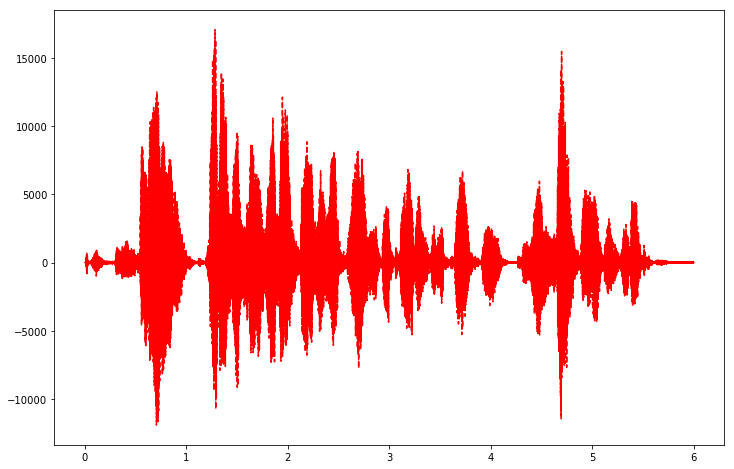

In [10]:
plt.figure(figsize=(12,8))
plt.plot(numpy.arange(0, len(signal))/sample_rate, signal, 'r--')
plt.show()

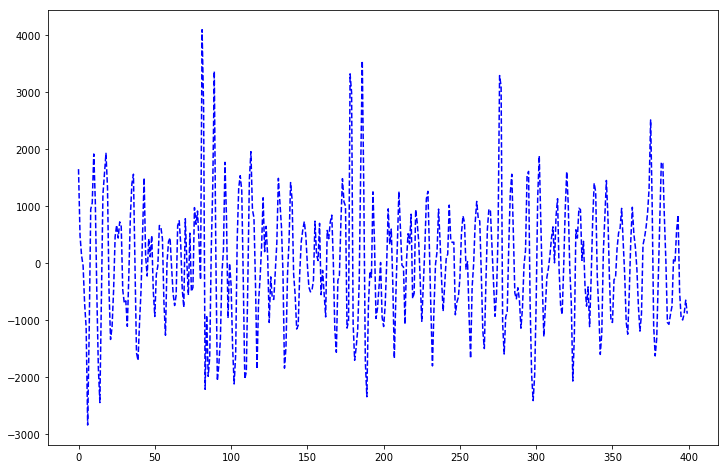

In [11]:
plt.figure(figsize=(12,8))
plt.plot(numpy.arange(0, frames.shape[1]), frames[200], 'b--')
plt.show()

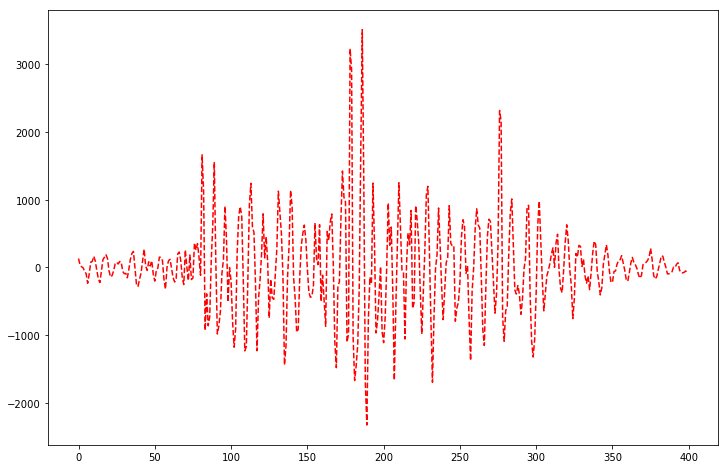

In [12]:
frames = smoothing_window(frames, frames.shape[1], window_type=window_type)
plt.figure(figsize=(12,8))
plt.plot(numpy.arange(0, frames.shape[1]), frames[200], 'r--')
plt.show()

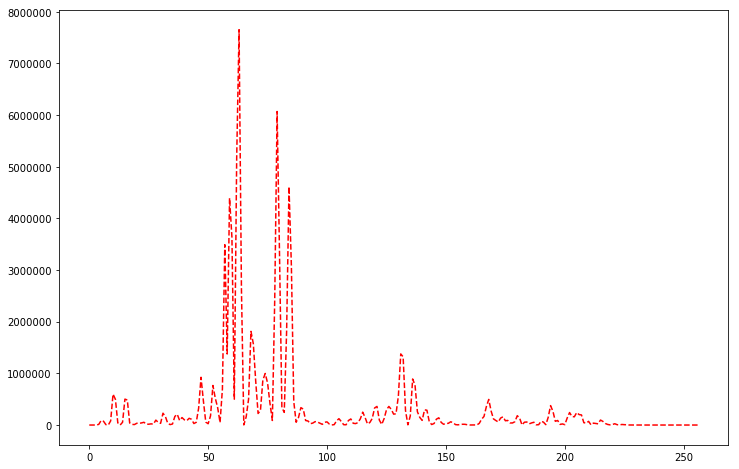

In [13]:
fft, power_frames = fourier_transform_and_power_spectrum(frames, nfft=nfft)
plt.figure(figsize=(12,8))
plt.plot(numpy.arange(0, power_frames.shape[1]), power_frames[200], 'r--')
plt.show()

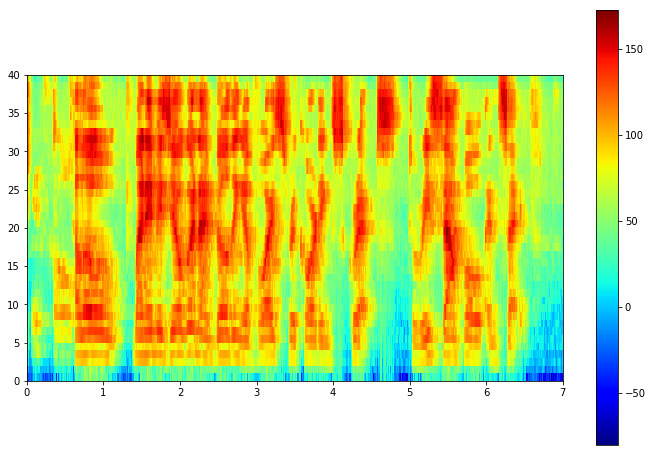

In [14]:
filter_banks = get_filter_banks(power_frames, sample_rate, nfilters, nfft)
plt.figure(figsize=(12,8))
plt.imshow(numpy.flipud(filter_banks.T), cmap=cm.jet, aspect=0.1, extent=[0,7,0,40])
plt.colorbar()
plt.show()

In [15]:
def get_mfccs(filter_banks ,num_ceps=12, cep_lifter=22):
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
    (nframes, ncoeff) = mfcc.shape
    n = numpy.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
    mfcc *= lift
    return mfcc

In [16]:
def delta(frames_features, n_frames_prec_follow=2):
    if n_frames_prec_follow < 1:
        raise ValueError('n_frames_prec_follow must be an integer >= 1')
    num_frames = len(frames_features)
    denominator = 2 * sum([i**2 for i in range(1, n_frames_prec_follow+1)])
    delta_feat = numpy.empty_like(frames_features)
    padded = numpy.pad(frames_features, ((n_frames_prec_follow, n_frames_prec_follow), (0, 0)), mode='edge')   # padded version of frames_features
    for t in range(num_frames):
        # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
        delta_feat[t] = numpy.dot(numpy.arange(-n_frames_prec_follow, n_frames_prec_follow+1), padded[t : t+2*n_frames_prec_follow+1]) / denominator
    return delta_feat

In [17]:
def normalize_mfccs_fbs_deltas(filter_banks, mfcc, mfcc_delta=None, mfcc_delta_deltas=None):
    filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
    mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
    if mfcc_delta is not None:
        mfcc_delta -= (numpy.mean(mfcc_delta, axis=0) + 1e-8)
    if mfcc_delta_deltas is not None:
        mfcc_delta_deltas -= (numpy.mean(mfcc_delta_deltas, axis=0) + 1e-8)
    return mfcc, filter_banks, mfcc_delta, mfcc_delta_deltas

In [41]:
#Get Mels coefficients which represent the spectral envelope of a single frame
mfcc = get_mfccs(filter_banks)
#Get the deltas of the MFCC coeficients which represent the trajectories of the MFCC coefficients over time
mfcc_delta = delta(mfcc, n_frames_prec_follow=2)
#Get the delta deltas which will provide the acceleration of the MFCC coefficients change
mfcc_delta_deltas = delta(mfcc_delta, n_frames_prec_follow=2)

norm_mfcc, norm_fb, norm_mfcc_delta, norm_mfcc_delta_deltas = normalize_mfccs_fbs_deltas(filter_banks,\
                                                                                         mfcc,\
                                                                                         mfcc_delta,\
                                                                                         mfcc_delta_deltas
                                                                                        )

mfccs_w_deltas = numpy.concatenate((norm_mfcc, norm_mfcc_delta, norm_mfcc_delta_deltas), axis=1)


Normalized MFCCs shape: (598, 36)
